In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(
    style='whitegrid',
    font_scale=0.8,
    rc={'lines.linewidth': 1.6, 'lines.markersize': 2},
    font='serif',
)

from mpl_toolkits import mplot3d

In [3]:
import numpy as np
import sklearn.gaussian_process.kernels
import supercubos
import ostrich.emulate
import ostrich.interpolate

In [31]:
n_2d = 128
param_2d_mins = np.array([0.5, 2, 1])
param_2d_maxes = np.array([1.5, 3, 2])
lh = supercubos.LatinSampler().get_lh_sample(param_2d_mins, param_2d_maxes, n_2d)
as_ = lh[:, 0]
bs = lh[:, 1]
cs = lh[:, 2]
 
xs = ys = np.linspace(-0.8, 1, 100)

In [32]:
def func(x, y, a, b, c):
    x = np.expand_dims(x, axis=(1, 2))
    y = np.expand_dims(y, axis=(0, 2))
    a = np.expand_dims(a, axis=(0, 1))
    b = np.expand_dims(b, axis=(0, 1))
    c = np.expand_dims(c, axis=(0, 1))
    return 1/((x**2 + y**2)**a + c)**b

In [33]:
zs = func(xs, ys, as_, bs, cs)

In [34]:
rand_test = supercubos.LatinSampler().get_rand_sample(param_2d_mins, param_2d_maxes, 1000)
as_test = rand_test[:, 0]
bs_test = rand_test[:, 1]
cs_test = rand_test[:, 2]
zs_test = func(xs, ys, as_test, bs_test, cs_test)

In [35]:
def plot_3d(xs, ys, zs, ax, color='black', alpha=0.2):
    X, Y = np.meshgrid(ys, xs)
    ax.plot_wireframe(
        X,
        Y,
        zs,
        color=color,
        alpha=alpha,
        rcount=40,
        ccount=40,
    )

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


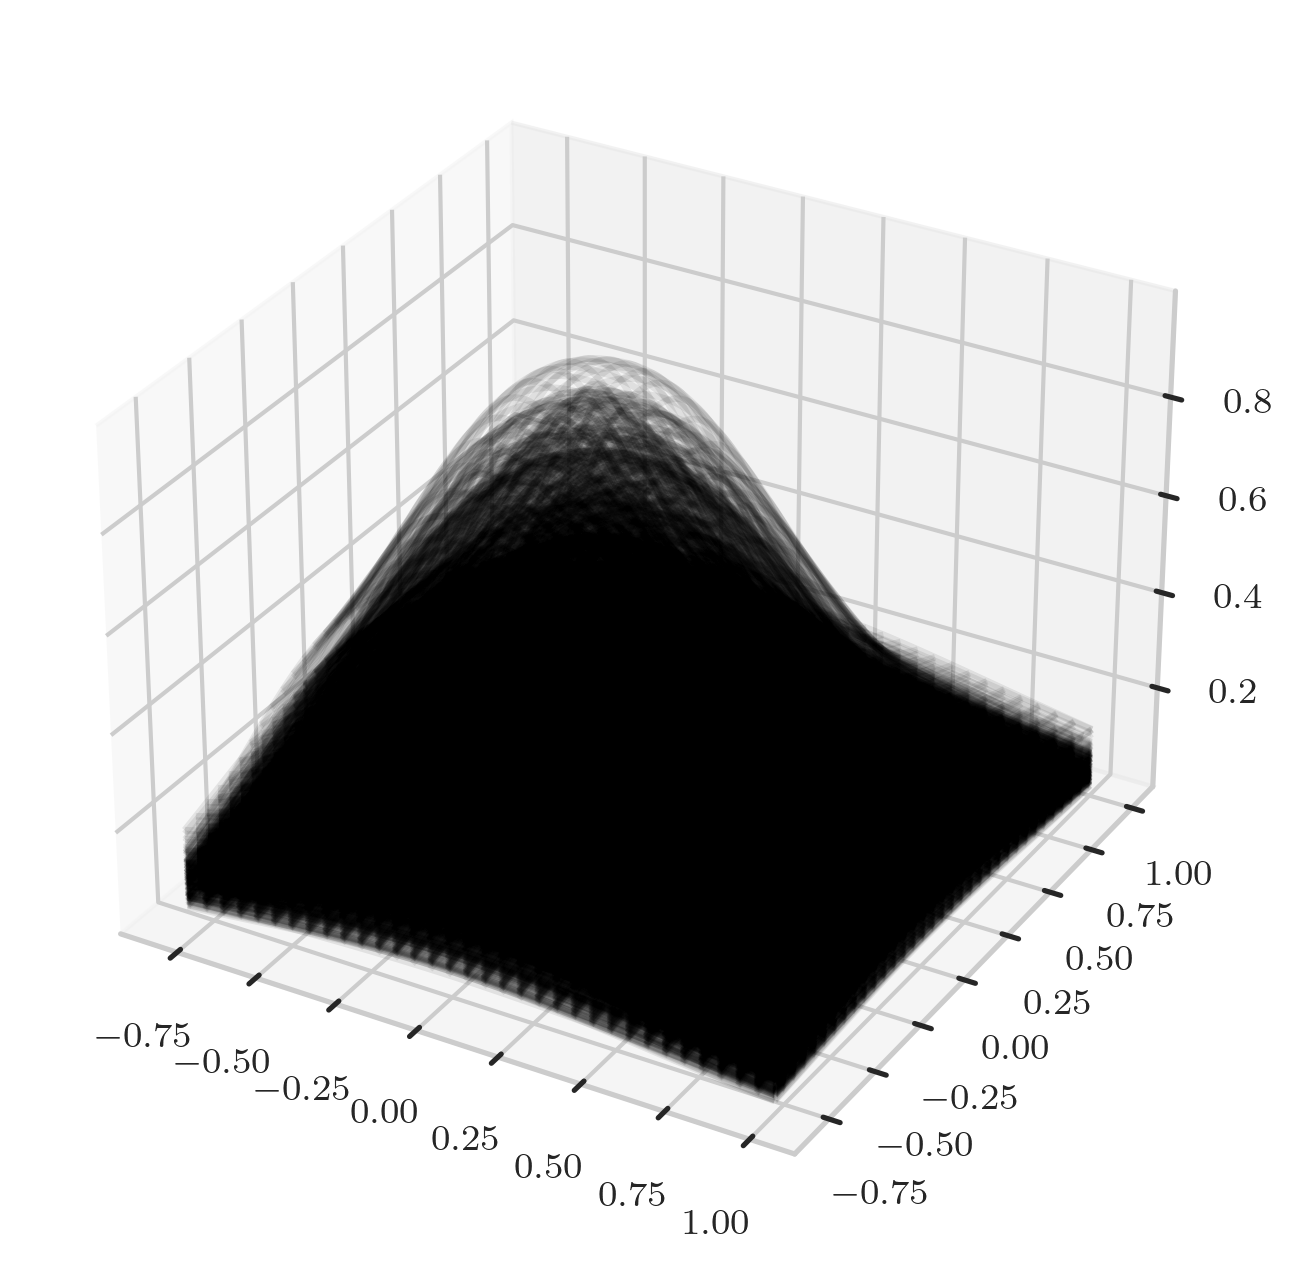

In [36]:
fig = plt.figure()
ax = mplot3d.Axes3D(fig)
for i in range(n_2d):
    plot_3d(xs, ys, zs[:, :, i], ax, alpha=0.08)

In [37]:
emulator = ostrich.emulate.PcaEmulator.create_from_data(
    lh,
    zs.reshape(-1, n_2d),
    ostrich.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': sklearn.gaussian_process.kernels.Matern()},
    num_components=10,
)

/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/sophia/.local/venv/ostrich/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


In [38]:
np.delete(lh, 1, 0).shape

(127, 3)

In [39]:
zs.shape

(100, 100, 128)

In [40]:
def get_errs(samps, data, true_coord, true_data):
    emulator = ostrich.emulate.PcaEmulator.create_from_data(
        samps,
        data.reshape(-1, n_2d-1),
        ostrich.interpolate.GaussianProcessInterpolator,
        interpolator_kwargs={'kernel': sklearn.gaussian_process.kernels.Matern()},
        num_components=10,
    )
    emulated = emulator(true_coord).reshape(100, 100)
    return (emulated - true_data)/true_data

In [41]:
import warnings
errs_drop_1 = np.empty((100, 100, n_2d))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(n_2d):
        if (100*i/n_2d)%10 == 0:
            print(100*(i/n_2d))
        errs_drop_1[:, :, i] = get_errs(
            np.delete(lh, i, 0),
            np.delete(zs, i, 2),
            lh[i, :][None, :],
            zs[:, :, i],
        )

0.0
50.0


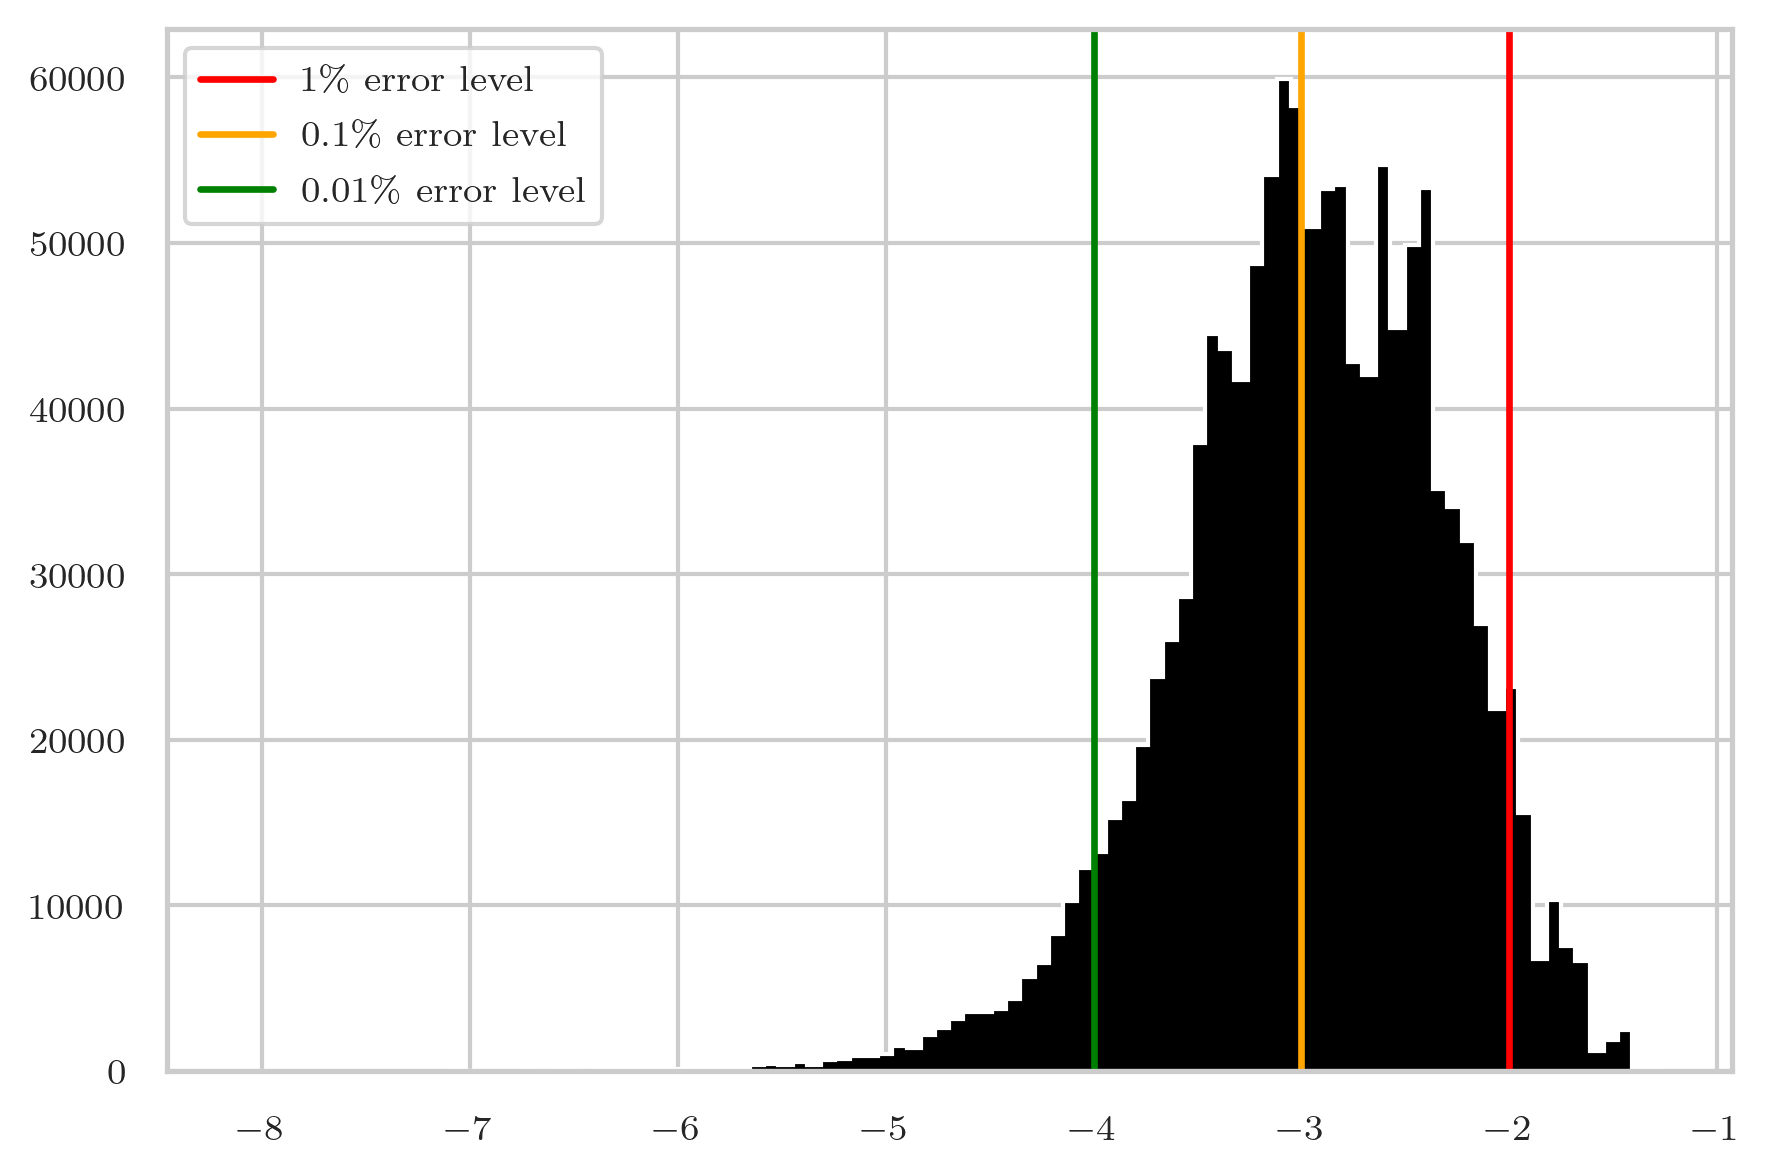

In [42]:
abs_errs = np.abs(errs_drop_1.flatten())
plt.hist(np.log10(abs_errs[abs_errs>0]), color='black', histtype='stepfilled', bins=100)
plt.axvline(-2, label='1\% error level', color='red')
plt.axvline(-3, label='0.1\% error level', color='orange')
plt.axvline(-4, label='0.01\% error level', color='green')
plt.legend(loc='best')
pass

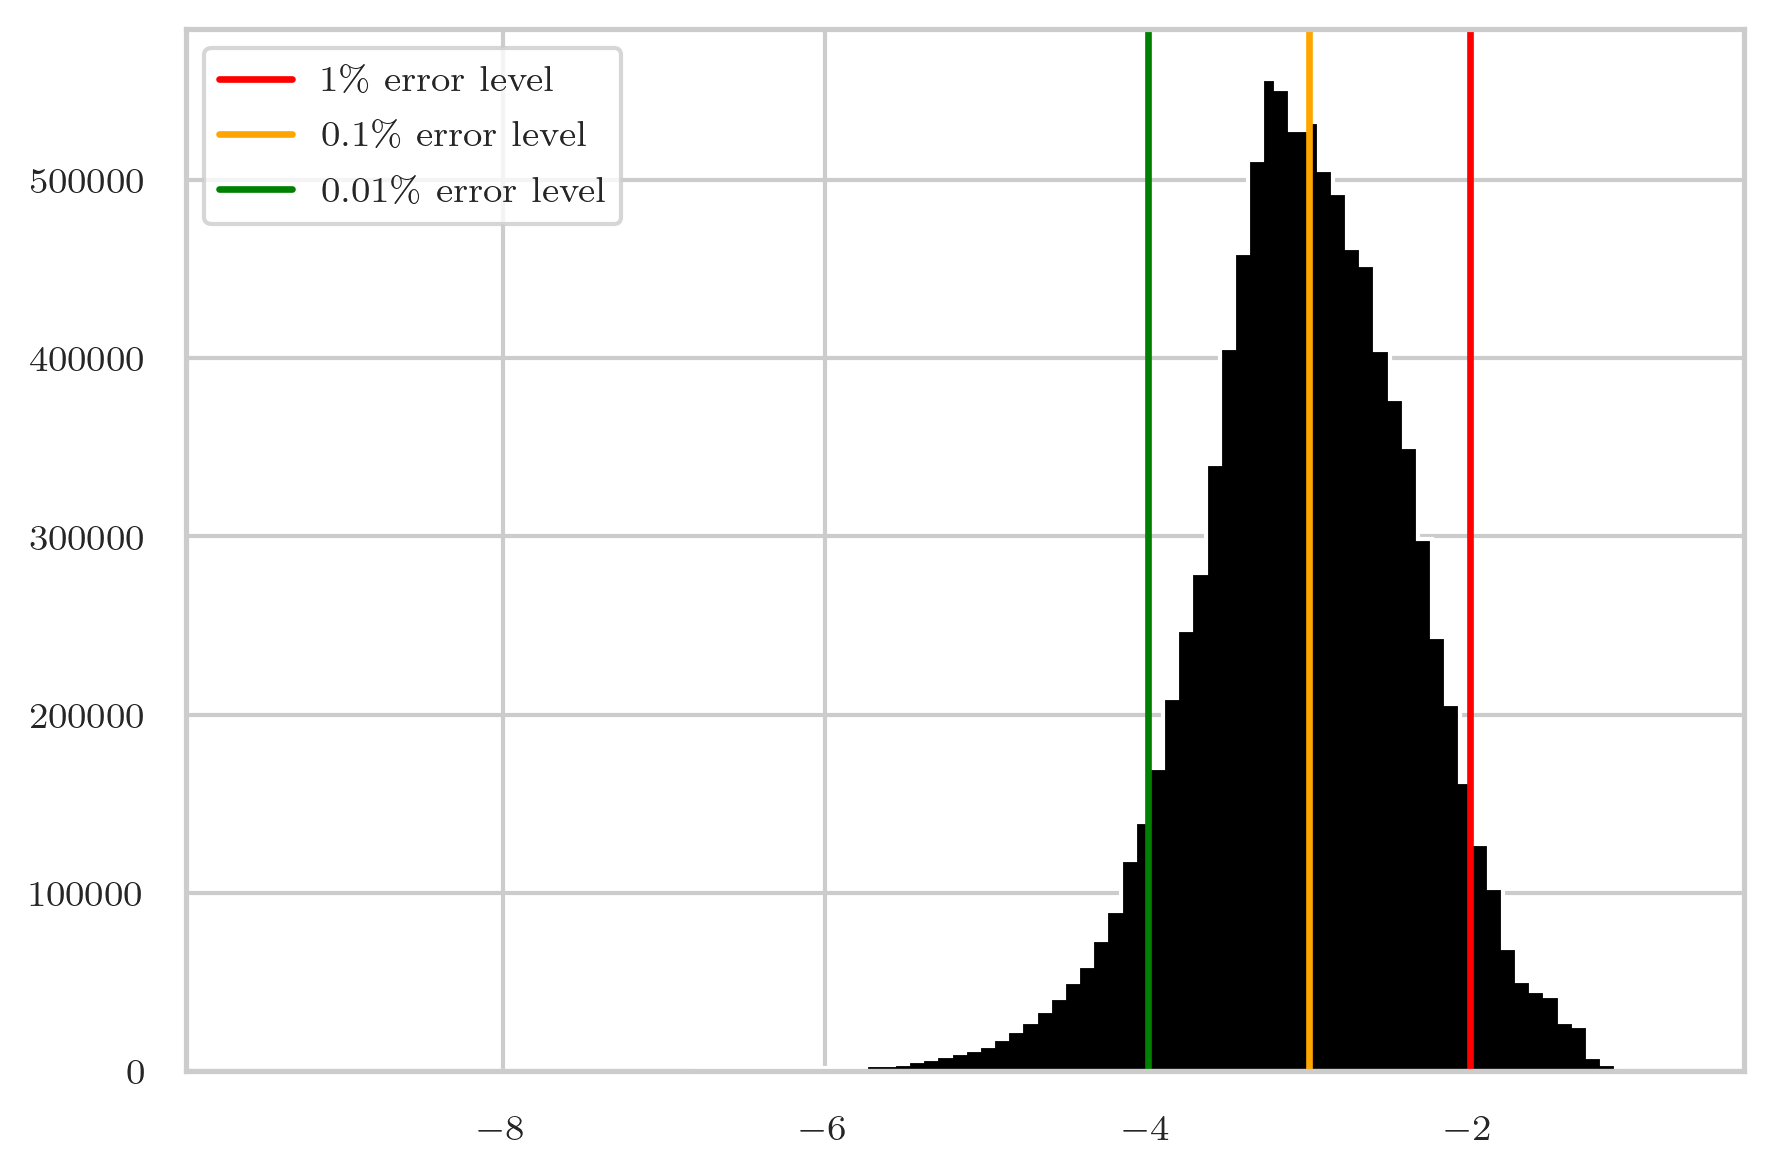

In [43]:
errs_test = (emulator(rand_test).reshape(100, 100, -1) - zs_test)/zs_test
abs_errs = np.abs(errs_test.flatten())
plt.hist(np.log10(abs_errs[abs_errs>0]), color='black', histtype='stepfilled', bins=100)
plt.axvline(-2, label='1\% error level', color='red')
plt.axvline(-3, label='0.1\% error level', color='orange')
plt.axvline(-4, label='0.01\% error level', color='green')
plt.legend(loc='best')
pass